This section now builds and trains a FCN on the MNIST dataset. Since there are 10 handwritten digit labels, this becomes a multi-class classification task. In terms of the architecture, this is as simple as changing the output dimension.\
However, the evaluation metrics involves a bit more consideration. In the previous section, we used Cross Entropy Loss. This is still applicable in the multi-class case. However, other commonly used metrics for binary classification like Logistic Loss will not be applicable, or may give wrong interpretations.

In [1]:
import torch
from torch import nn

from torch.utils.data import random_split, DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Grayscale

gpu_available = torch.cuda.is_available()
print(f'{gpu_available=}')

gpu_available=True


In [2]:
import sys
sys.path.append('../..')

import math
import matplotlib.pyplot as plt

from CustomDL.utils import train_model, test_model

# Load MNIST dataset

In [3]:
digits_dataset = MNIST(
    root='../../data', # the folder where data eixsts/is stored,
    download=True,
    transform=ToTensor() # The image are PIL format, this transform to Tensor objects
)
print(digits_dataset.data.shape)

train_data, test_data = random_split(digits_dataset, [.8, .2])

torch.Size([60000, 28, 28])


# Defining a Model

In [4]:
class OneClassfier(nn.Module):
    def __init__(self,
        hidden_dims: int,
        activation_fn: nn.Module
    ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_dims),
            activation_fn,
            nn.Linear(hidden_dims, hidden_dims),
            activation_fn,
            nn.Linear(hidden_dims, hidden_dims),
            activation_fn,
            nn.Linear(hidden_dims, 10)
        )

    def forward(self, image):
        return self.layers(image)

In [13]:
model = OneClassfier(100, nn.ReLU())
if gpu_available:
    model.cuda()

# Training and Evaluation

In [7]:
def run_epochs(
    epochs: int,
    model: nn.Module,
    train_loader: tuple[DataLoader, DataLoader],
    test_loader: tuple[DataLoader, DataLoader],
    loss_fn: nn.Module,
    optimizer: nn.Module
):
    num_dig = int(math.log10(epochs)) + 1
    update_rate = 1 if epochs <= 20 else 10

    for epoch in range(epochs):
        if not epoch % update_rate:
            print(f"Epoch {epoch + 1:>{num_dig}}/{epochs}", end=' || ')
        train_model(model, train_loader, loss_fn, optimizer,
                    use_gpu=gpu_available)
        loss, acc = test_model(model, test_loader, loss_fn, True,
                               use_gpu=gpu_available)
        if not epoch % update_rate:
            print(f"Average Loss: {loss:.6f} | {acc * 100:.4f}%")

In [14]:
batch_size = 64
learning_rate = 0.001

train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

sml = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

In [15]:
epochs = 20

run_epochs(
    epochs, model,
    train_loader, test_loader,
    sml, optimizer
)

Epoch  1/20 || Average Loss: 2.302891 | 8.9833%
Epoch  2/20 || Average Loss: 2.297696 | 8.9833%
Epoch  3/20 || Average Loss: 2.292203 | 8.9833%
Epoch  4/20 || Average Loss: 2.285771 | 9.0667%
Epoch  5/20 || Average Loss: 2.277879 | 15.4583%
Epoch  6/20 || Average Loss: 2.267418 | 22.1917%
Epoch  7/20 || Average Loss: 2.253236 | 27.5750%
Epoch  8/20 || Average Loss: 2.233504 | 30.6083%
Epoch  9/20 || Average Loss: 2.204786 | 33.8000%
Epoch 10/20 || Average Loss: 2.161072 | 36.9917%
Epoch 11/20 || Average Loss: 2.092691 | 39.9083%
Epoch 12/20 || Average Loss: 1.987840 | 43.8667%
Epoch 13/20 || Average Loss: 1.837259 | 49.3833%
Epoch 14/20 || Average Loss: 1.640134 | 57.5417%
Epoch 15/20 || Average Loss: 1.414235 | 65.2250%
Epoch 16/20 || Average Loss: 1.204940 | 69.9417%
Epoch 17/20 || Average Loss: 1.041373 | 72.5250%
Epoch 18/20 || Average Loss: 0.920221 | 74.6333%
Epoch 19/20 || Average Loss: 0.830743 | 76.5083%
Epoch 20/20 || Average Loss: 0.764431 | 78.0417%


In [16]:
torch.save(
    {'epochs': epochs, 'hidden_dims': 100, 'model': model.state_dict(), 'optimizer': optimizer.state_dict()},
    './output/digits_classifier_1.pth'
)

# Inference

In [17]:
import torchvision

In [18]:
model.cpu()
model.eval()

OneClassfier(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=10, bias=True)
  )
)

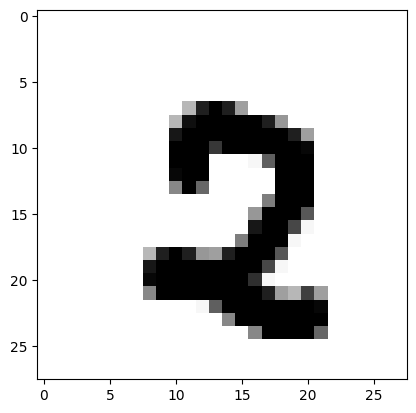

In [40]:
sample_img = torchvision.io.read_image('./data/num2.png')
sample_img = Grayscale(1)(sample_img[:3])
sample_img = (255 - sample_img) / 255
plt.imshow(sample_img[0], cmap='gray_r')

In [41]:
pred_vals = model(sample_img.unsqueeze(0)).detach()
pred_probs = nn.Softmax(1)(pred_vals)
prediction = pred_vals.argmax().item()

print(f"""Output values:
    {pred_vals}
Class 'Probabilities':
    {pred_probs}
Prediction: {prediction}""")

Output values:
    tensor([[ 1.5933, -5.7504, -0.3954,  0.4799,  1.0465,  2.3509,  0.1406,  1.0806,
          1.5156,  1.2748]])
Class 'Probabilities':
    tensor([[1.5008e-01, 9.7051e-05, 2.0541e-02, 4.9288e-02, 8.6858e-02, 3.2014e-01,
         3.5109e-02, 8.9877e-02, 1.3886e-01, 1.0914e-01]])
Prediction: 5


#

Note:
- Given that images of same class have fairly homogenous form, the model have no problem fitting into the data. This is as expected.
- However, the model can only predict a images of fixed size 28x28. Thus, if we are required to do inference on images of different sizes, we will need to manually preprocess those images or maybe use a different architecture that can do this prepocessing automatically for us.
- Furthermore, if we increase the image size, we need more weights and biases to optimize. We can think of these weights and biases as elements in the netwok that help differentiate between one number and another. If we have too many criteria to differentiate numbers, it will create unnecessary complexity and thus prone to overfitting.

For the last point, we can avoid such an issue by finding a way to extract some of the more prominent features inside an image, and then pass those extracted features into the network. We also notice that different numebrs have subtle relationships between the neighbouring pixels. We can pick up these relationships by finding a suitable filter to apply over the image. This then leads to the idea of convolving the image with a fixed kernel that have the appropriate weights.\
When we integrate this convolution operation within the network, one obtains a Convolutional Neural Network. This architecture is explored further in the Convoluntional Network topic. 